### Deep learning model training.


In [15]:
import time
import torch
import random
import pandas as pd
import torch.nn as nn
from glob import glob
from notebooks import config
from utils.imgShow import imsShow
from model import unet, unet_scales 
from utils.utils import read_scenes
from utils.metrics import oa_binary, miou_binary
from utils.dataloader import SceneArraySet_scales, PatchPathSet_scales


In [2]:
patch_size = 256
higher_patch_size = 1024


In [3]:
### traset
paths_scene_tra, paths_truth_tra = config.paths_scene_tra, config.paths_truth_tra
paths_dem_tra = config.paths_dem_tra
# paths_dem_tra = config.paths_dem_adjust_tra
print(f'train scenes: {len(paths_scene_tra)}')
### valset
paths_valset = sorted(glob(f'data/dset/valset/patch_{higher_patch_size}/*'))  ## for model prediction 
# paths_patch_valset = sorted(glob(f'data/dset/valset/patch_{patch_size}_dem_adjust/*'))
print(f'vali patch: {len(paths_valset)}')


train scenes: 48
vali patch: 293


### dataset loading

In [4]:
## load traset
scenes_dem_arr, truths_arr = read_scenes(paths_scene_tra, 
                                            paths_truth_tra, 
                                            paths_dem_tra) 
print('traset:', len(scenes_dem_arr))


traset: 48


In [5]:
# Create dataset instances
tra_data = SceneArraySet_scales(scenes_arr=scenes_dem_arr,    
                          truths_arr=truths_arr,   
                          patch_size=256,   
                          higher_patch_size=1024,   
                          patch_resize=True)   
val_data = PatchPathSet_scales(paths_valset=paths_valset,   
                          higher_patch_size=1024,  
                          patch_size=256,  
                          patch_resize=True)     


In [6]:
tra_loader = torch.utils.data.DataLoader(tra_data, 
                                         batch_size=4, 
                                         shuffle=True, 
                                         num_workers=10)
val_loader = torch.utils.data.DataLoader(val_data, 
                                         batch_size=4, 
                                         num_workers=10)


#### Model training

In [7]:
model = unet_scales(num_bands_local=7, 
                    num_bands_global=7, 
                    patch_size=patch_size,
                    higher_patch_size=higher_patch_size)


In [8]:
tra_loader_iter = iter(tra_loader)
val_loader_iter = iter(val_loader)
tra_one = next(tra_loader_iter)
val_one = next(val_loader_iter)
pred_local, pred_global, pred_global2local = model(tra_one[0], tra_one[2])


In [9]:
### create loss and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)  
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, \
                                          mode='min', factor=0.6, patience=20)


In [10]:
loss_bce = nn.BCELoss()
loss_mse = nn.MSELoss() 

def loss_rmse(y_pred, y_true):
    mse = torch.mean((y_pred - y_true)**2)
    return torch.sqrt(mse)

class Loss_scales(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss_global = nn.BCELoss()
        self.loss_local = nn.MSELoss()
    def forward(self, x_local, y_local, x_global,  y_global):
        loss_global = self.loss_global(x_global, y_global)
        loss_local = self.loss_local(x_local, y_local)
        return loss_local + loss_global
loss_scales = Loss_scales()


In [11]:
'''------train step------'''
def train_step(x_patch,
               y_patch,
               x_higher_patch, 
               y_higher_patch,
               model, 
               optimizer, 
               loss_fn):
    optimizer.zero_grad()
    pred_local, pred_global, _ = model(x_patch, x_higher_patch)
    # loss = loss_fn(pred_local, y_patch.float())
    loss = loss_fn(x_local=pred_local, 
                    y_local=y_patch.float(), 
                    x_global=pred_global, 
                    y_global=y_higher_patch.float())
    loss.backward()
    optimizer.step()    
    miou = miou_binary(pred=pred_local, truth=y_patch, device=x_patch.device)
    oa = oa_binary(pred=pred_local, truth=y_patch, device=x_patch.device)
    return loss, miou, oa
'''------validation step------'''
def val_step(x_patch,
             y_patch,
             x_higher_patch,
             y_higher_patch, 
             model,
             loss_fn):
    model.eval()
    with torch.no_grad():
        pred_local, pred_global, _ = model(x_patch, x_higher_patch)
        # loss = loss_fn(pred_local, y_patch.float())
        loss = loss_fn(x_local=pred_local, 
                       y_local=y_patch.float(), 
                       x_global=pred_global, 
                       y_global=y_higher_patch.float())
    miou = miou_binary(pred=pred_local, truth=y_patch, device=x_patch.device)
    oa = oa_binary(pred=pred_local, truth=y_patch, device=x_patch.device)
    return loss, miou, oa

'''------train loops------'''
def train_loops(model,
                loss_fn, 
                optimizer, 
                tra_loader, 
                val_loader, 
                epoches, 
                device, 
                lr_scheduler=None):
    tra_loss_loops, tra_miou_loops, tra_oa_loops = [], [], []
    val_loss_loops, val_miou_loops, val_oa_loops = [], [], []
    model = model.to(device)
    size_tra_loader = len(tra_loader)
    size_val_loader = len(val_loader)
    for epoch in range(epoches):
        start = time.time()
        tra_loss, val_loss = 0, 0
        tra_miou, val_miou = 0, 0
        tra_oa, val_oa = 0, 0
        '''-----train the model-----'''
        for x_patch, y_patch, x_higher_patch, y_higher_patch in tra_loader:
            x_patch, y_patch, x_higher_patch, y_higher_patch = x_patch.to(device), y_patch.to(device), x_higher_patch.to(device), y_higher_patch.to(device)
            loss, miou, oa = train_step(x_patch=x_patch, 
                                        y_patch=y_patch,
                                        x_higher_patch=x_higher_patch,
                                        y_higher_patch=y_higher_patch,
                                        model=model,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn)                                        
            tra_loss += loss.item()
            tra_miou += miou.item()
            tra_oa += oa.item()
        if lr_scheduler:
            lr_scheduler.step(tra_loss)    # if using ReduceLROnPlateau
        '''----- validation the model: time consuming -----'''
        if (epoch+1) < 100: 
            tra_loss = tra_loss/size_tra_loader
            val_loss = val_loss/size_val_loader
            tra_miou = tra_miou/size_tra_loader
            print(f'Ep{epoch+1}: tra-> Loss:{tra_loss:.3f},Oa:{tra_oa:.3f},Miou:{tra_miou:.3f}, \
                                time:{time.time()-start:.1f}s')
            continue
        for x_patch, y_patch, x_higher_patch, y_higher_patch in val_loader:
            x_patch, y_patch, x_higher_patch, y_higher_patch = x_patch.to(device), y_patch.to(device), x_higher_patch.to(device), y_higher_patch.to(device)
            loss, miou, oa = val_step(x_patch=x_patch, 
                                    y_patch=y_patch, 
                                    x_higher_patch=x_higher_patch, 
                                    y_higher_patch=y_higher_patch, 
                                    model=model, 
                                    loss_fn=loss_fn)            
            val_loss += loss.item()
            val_miou += miou.item()
            val_oa += oa.item()
        ## Accuracy
        tra_loss = tra_loss/size_tra_loader
        val_loss = val_loss/size_val_loader
        tra_miou = tra_miou/size_tra_loader
        val_miou = val_miou/size_val_loader
        tra_oa = tra_oa/size_tra_loader
        val_oa = val_oa/size_val_loader
        tra_loss_loops.append(tra_loss); tra_miou_loops.append(tra_miou); tra_oa_loops.append(tra_oa)
        val_loss_loops.append(val_loss); val_miou_loops.append(val_miou); val_oa_loops.append(val_oa)
        print(f'Ep{epoch+1}: tra-> Loss:{tra_loss:.3f},Oa:{tra_oa:.3f},Miou:{tra_miou:.3f}, '
                f'val-> Loss:{val_loss:.3f},Oa:{val_oa:.3f}, Miou:{val_miou:.3f},time:{time.time()-start:.1f}s')
        ## show the result
        if (epoch+1)%10 == 0:
            model.eval()
            sam_index = random.randrange(len(val_data))
            patch, ptruth, higher_patch, higher_ptruth = val_data[sam_index]
            patch, ptruth = torch.unsqueeze(patch.float(), 0).to(device), ptruth.to(device)
            higher_patch, higher_ptruth = torch.unsqueeze(higher_patch.float(), 0).to(device), torch.unsqueeze(higher_ptruth.float(), 0).to(device)
            pred_local, pred_global, pred_global2local = model(patch, higher_patch)
            ## convert to numpy and plot
            patch = patch[0].to('cpu').detach().numpy().transpose(1,2,0)
            pdem = patch[:,:, -1]
            pred_patch = pred_local[0].to('cpu').detach().numpy()
            pred_global2local = pred_global2local[0].to('cpu').detach().numpy()
            ptruth = ptruth.to('cpu').detach().numpy()
            pred_higher_patch = pred_global[0].to('cpu').detach().numpy()
            higher_patch = higher_patch[0].to('cpu').detach().numpy().transpose(1,2,0)
            higher_ptruth = higher_ptruth.to('cpu').detach().numpy()
            imsShow([higher_patch, pred_higher_patch, patch, pdem, pred_global2local, pred_patch, ptruth], 
                    clip_list = (2,0,2,2,0,0,0),
                    img_name_list=['input_higher_patch', 'pred_higher_patch', 'input_patch', 
                                   'pdem', 'pred_global2local', 'pred', 'truth'],                     
                    figsize=(20,3))
    metrics = {'tra_loss':tra_loss_loops, 'tra_miou':tra_miou_loops, 'tra_oa': tra_oa_loops, 
                    'val_loss': val_loss_loops, 'val_miou': val_miou_loops, 'val_oa': val_oa_loops}
    return metrics 


Ep1: tra-> Loss:0.614,Oa:8.787,Miou:0.630,                                 time:5.1s
Ep2: tra-> Loss:0.350,Oa:10.614,Miou:0.802,                                 time:4.8s
Ep3: tra-> Loss:0.316,Oa:10.138,Miou:0.745,                                 time:5.1s
Ep4: tra-> Loss:0.245,Oa:11.211,Miou:0.870,                                 time:5.0s
Ep5: tra-> Loss:0.222,Oa:11.283,Miou:0.889,                                 time:4.5s
Ep6: tra-> Loss:0.256,Oa:10.630,Miou:0.812,                                 time:4.2s
Ep7: tra-> Loss:0.252,Oa:10.764,Miou:0.837,                                 time:4.8s
Ep8: tra-> Loss:0.235,Oa:10.627,Miou:0.824,                                 time:4.7s
Ep9: tra-> Loss:0.201,Oa:10.842,Miou:0.855,                                 time:4.3s
Ep10: tra-> Loss:0.193,Oa:10.475,Miou:0.832,                                 time:4.0s
Ep11: tra-> Loss:0.266,Oa:10.606,Miou:0.808,                                 time:4.7s
Ep12: tra-> Loss:0.231,Oa:10.581,Miou:0.817,         

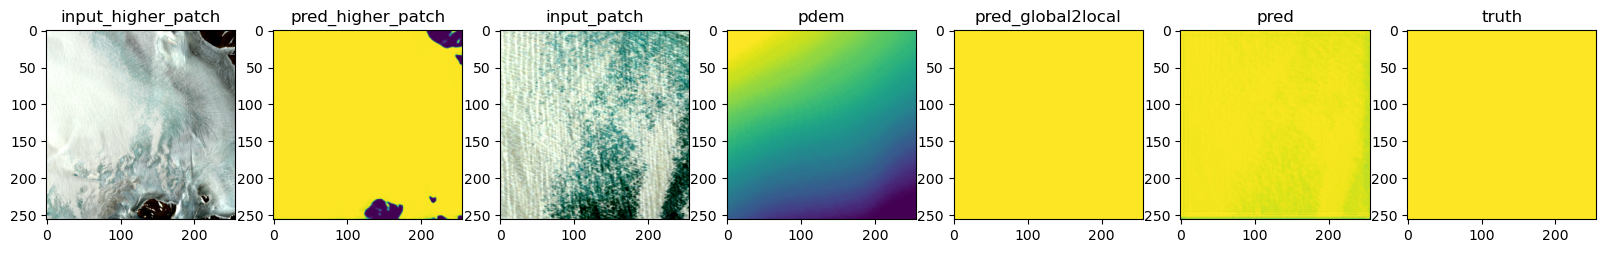

Ep101: tra-> Loss:0.096,Oa:0.905,Miou:0.852, val-> Loss:0.121,Oa:0.905, Miou:0.835,time:6.2s
Ep102: tra-> Loss:0.089,Oa:0.939,Miou:0.891, val-> Loss:0.112,Oa:0.913, Miou:0.848,time:6.3s
Ep103: tra-> Loss:0.089,Oa:0.974,Miou:0.925, val-> Loss:0.110,Oa:0.910, Miou:0.850,time:6.6s
Ep104: tra-> Loss:0.088,Oa:0.937,Miou:0.898, val-> Loss:0.149,Oa:0.901, Miou:0.838,time:6.6s
Ep105: tra-> Loss:0.083,Oa:0.934,Miou:0.908, val-> Loss:0.117,Oa:0.922, Miou:0.855,time:6.9s
Ep106: tra-> Loss:0.071,Oa:0.973,Miou:0.949, val-> Loss:0.136,Oa:0.901, Miou:0.838,time:6.9s
Ep107: tra-> Loss:0.068,Oa:0.976,Miou:0.953, val-> Loss:0.100,Oa:0.916, Miou:0.852,time:6.7s
Ep108: tra-> Loss:0.070,Oa:0.966,Miou:0.923, val-> Loss:0.102,Oa:0.920, Miou:0.857,time:6.5s
Ep109: tra-> Loss:0.086,Oa:0.956,Miou:0.917, val-> Loss:0.208,Oa:0.892, Miou:0.829,time:6.5s
Ep110: tra-> Loss:0.142,Oa:0.937,Miou:0.895, val-> Loss:0.172,Oa:0.899, Miou:0.826,time:7.2s


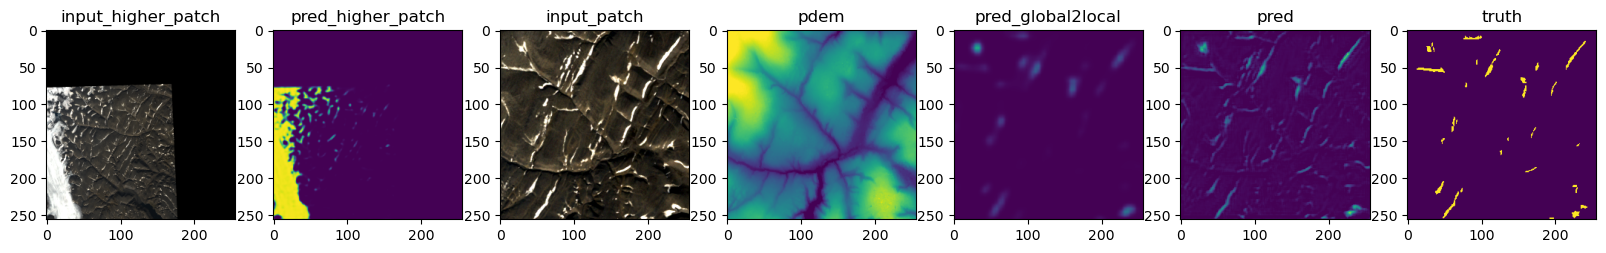

Ep111: tra-> Loss:0.104,Oa:0.977,Miou:0.895, val-> Loss:0.175,Oa:0.898, Miou:0.826,time:8.6s
Ep112: tra-> Loss:0.132,Oa:0.919,Miou:0.871, val-> Loss:0.152,Oa:0.901, Miou:0.828,time:8.5s
Ep113: tra-> Loss:0.095,Oa:0.951,Miou:0.870, val-> Loss:0.133,Oa:0.904, Miou:0.832,time:7.8s
Ep114: tra-> Loss:0.079,Oa:0.966,Miou:0.913, val-> Loss:0.135,Oa:0.907, Miou:0.837,time:8.2s
Ep115: tra-> Loss:0.090,Oa:0.977,Miou:0.948, val-> Loss:0.115,Oa:0.912, Miou:0.835,time:8.2s
Ep116: tra-> Loss:0.079,Oa:0.931,Miou:0.891, val-> Loss:0.135,Oa:0.903, Miou:0.835,time:8.3s
Ep117: tra-> Loss:0.099,Oa:0.969,Miou:0.927, val-> Loss:0.122,Oa:0.921, Miou:0.843,time:8.4s
Ep118: tra-> Loss:0.079,Oa:0.976,Miou:0.922, val-> Loss:0.107,Oa:0.911, Miou:0.845,time:8.6s
Ep119: tra-> Loss:0.090,Oa:0.974,Miou:0.934, val-> Loss:0.105,Oa:0.919, Miou:0.851,time:8.3s
Ep120: tra-> Loss:0.071,Oa:0.959,Miou:0.933, val-> Loss:0.101,Oa:0.914, Miou:0.853,time:8.6s


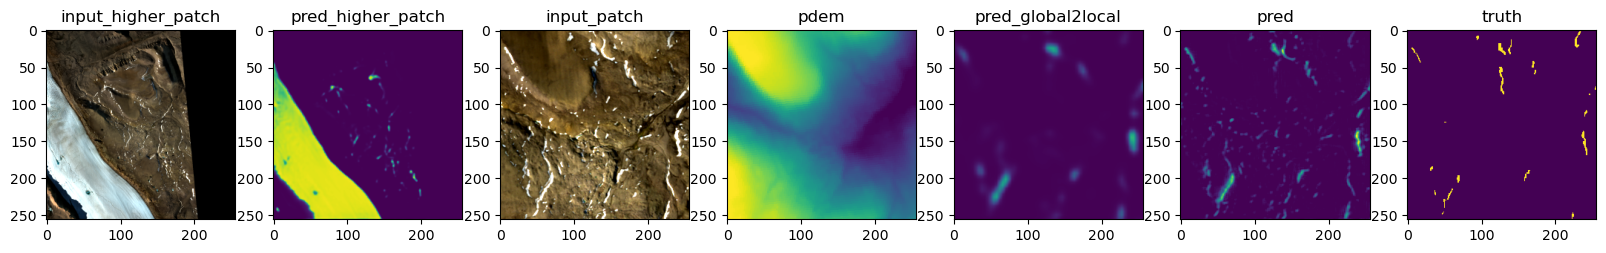

Ep121: tra-> Loss:0.069,Oa:0.969,Miou:0.942, val-> Loss:0.097,Oa:0.922, Miou:0.867,time:8.6s
Ep122: tra-> Loss:0.084,Oa:0.970,Miou:0.939, val-> Loss:0.103,Oa:0.926, Miou:0.857,time:8.1s
Ep123: tra-> Loss:0.075,Oa:0.979,Miou:0.949, val-> Loss:0.098,Oa:0.920, Miou:0.863,time:8.3s
Ep124: tra-> Loss:0.074,Oa:0.968,Miou:0.925, val-> Loss:0.094,Oa:0.923, Miou:0.865,time:8.3s
Ep125: tra-> Loss:0.070,Oa:0.971,Miou:0.938, val-> Loss:0.100,Oa:0.929, Miou:0.864,time:8.7s
Ep126: tra-> Loss:0.075,Oa:0.939,Miou:0.915, val-> Loss:0.094,Oa:0.924, Miou:0.875,time:8.4s
Ep127: tra-> Loss:0.069,Oa:0.979,Miou:0.921, val-> Loss:0.094,Oa:0.923, Miou:0.876,time:8.7s
Ep128: tra-> Loss:0.086,Oa:0.963,Miou:0.917, val-> Loss:0.094,Oa:0.924, Miou:0.871,time:8.5s
Ep129: tra-> Loss:0.066,Oa:0.973,Miou:0.951, val-> Loss:0.087,Oa:0.925, Miou:0.873,time:8.3s
Ep130: tra-> Loss:0.069,Oa:0.968,Miou:0.915, val-> Loss:0.089,Oa:0.932, Miou:0.876,time:7.7s


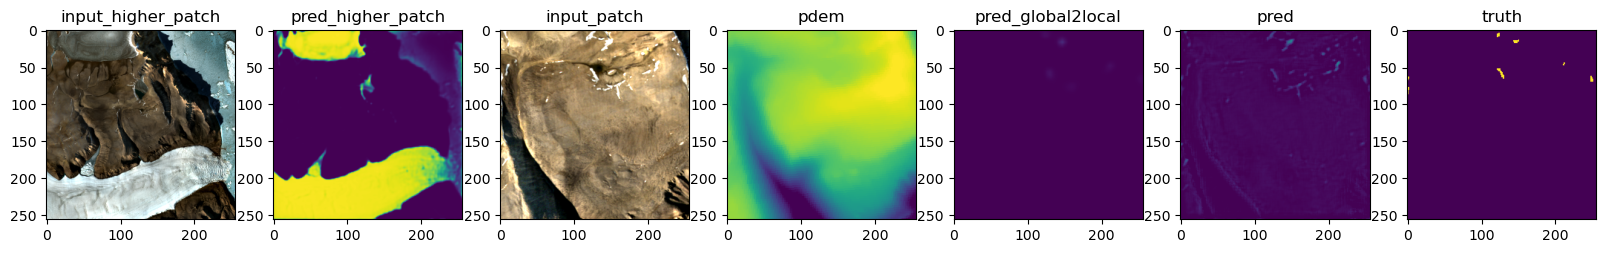

Ep131: tra-> Loss:0.061,Oa:0.977,Miou:0.945, val-> Loss:0.090,Oa:0.924, Miou:0.871,time:8.3s
Ep132: tra-> Loss:0.060,Oa:0.977,Miou:0.953, val-> Loss:0.091,Oa:0.929, Miou:0.874,time:7.8s
Ep133: tra-> Loss:0.061,Oa:0.897,Miou:0.872, val-> Loss:0.089,Oa:0.925, Miou:0.872,time:8.4s
Ep134: tra-> Loss:0.063,Oa:0.976,Miou:0.953, val-> Loss:0.096,Oa:0.934, Miou:0.870,time:8.6s
Ep135: tra-> Loss:0.071,Oa:0.956,Miou:0.923, val-> Loss:0.091,Oa:0.921, Miou:0.873,time:9.0s
Ep136: tra-> Loss:0.061,Oa:0.960,Miou:0.939, val-> Loss:0.092,Oa:0.927, Miou:0.873,time:8.4s
Ep137: tra-> Loss:0.067,Oa:0.974,Miou:0.925, val-> Loss:0.088,Oa:0.922, Miou:0.875,time:7.9s
Ep138: tra-> Loss:0.067,Oa:0.933,Miou:0.904, val-> Loss:0.096,Oa:0.927, Miou:0.864,time:8.6s
Ep139: tra-> Loss:0.063,Oa:0.977,Miou:0.913, val-> Loss:0.093,Oa:0.920, Miou:0.865,time:8.3s
Ep140: tra-> Loss:0.070,Oa:0.964,Miou:0.941, val-> Loss:0.104,Oa:0.926, Miou:0.859,time:8.6s


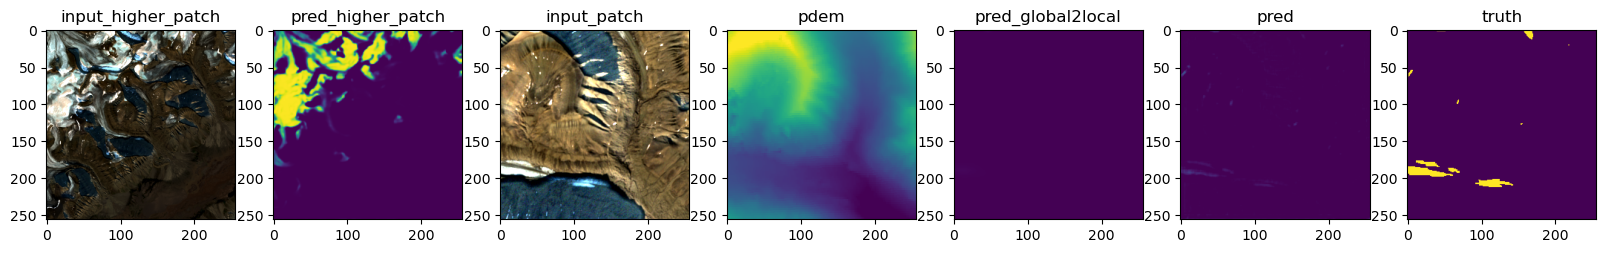

Ep141: tra-> Loss:0.061,Oa:0.972,Miou:0.945, val-> Loss:0.098,Oa:0.915, Miou:0.863,time:7.6s
Ep142: tra-> Loss:0.065,Oa:0.979,Miou:0.954, val-> Loss:0.098,Oa:0.929, Miou:0.867,time:8.7s
Ep143: tra-> Loss:0.067,Oa:0.964,Miou:0.930, val-> Loss:0.087,Oa:0.930, Miou:0.877,time:8.2s
Ep144: tra-> Loss:0.065,Oa:0.937,Miou:0.896, val-> Loss:0.089,Oa:0.927, Miou:0.871,time:8.4s
Ep145: tra-> Loss:0.063,Oa:0.976,Miou:0.949, val-> Loss:0.092,Oa:0.924, Miou:0.876,time:8.4s
Ep146: tra-> Loss:0.057,Oa:0.965,Miou:0.937, val-> Loss:0.096,Oa:0.923, Miou:0.872,time:8.6s
Ep147: tra-> Loss:0.061,Oa:0.972,Miou:0.920, val-> Loss:0.091,Oa:0.921, Miou:0.874,time:8.4s
Ep148: tra-> Loss:0.056,Oa:0.973,Miou:0.950, val-> Loss:0.089,Oa:0.931, Miou:0.877,time:8.2s
Ep149: tra-> Loss:0.070,Oa:0.972,Miou:0.948, val-> Loss:0.124,Oa:0.907, Miou:0.844,time:7.4s
Ep150: tra-> Loss:0.076,Oa:0.955,Miou:0.880, val-> Loss:0.095,Oa:0.923, Miou:0.859,time:7.9s


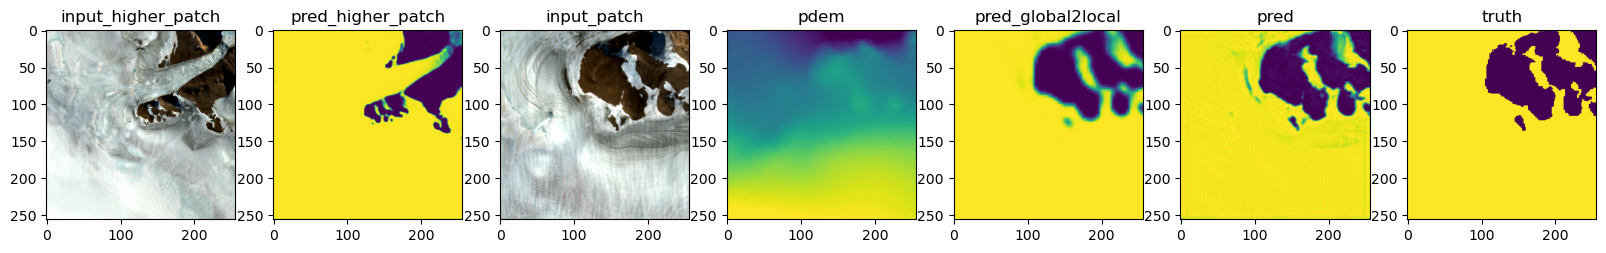

Ep151: tra-> Loss:0.064,Oa:0.979,Miou:0.942, val-> Loss:0.123,Oa:0.904, Miou:0.847,time:8.0s
Ep152: tra-> Loss:0.061,Oa:0.962,Miou:0.905, val-> Loss:0.098,Oa:0.918, Miou:0.861,time:8.0s
Ep153: tra-> Loss:0.059,Oa:0.978,Miou:0.951, val-> Loss:0.097,Oa:0.917, Miou:0.862,time:8.0s
Ep154: tra-> Loss:0.062,Oa:0.956,Miou:0.930, val-> Loss:0.096,Oa:0.916, Miou:0.863,time:7.7s
Ep155: tra-> Loss:0.056,Oa:0.915,Miou:0.886, val-> Loss:0.095,Oa:0.915, Miou:0.863,time:7.7s
Ep156: tra-> Loss:0.059,Oa:0.977,Miou:0.913, val-> Loss:0.092,Oa:0.918, Miou:0.868,time:8.1s
Ep157: tra-> Loss:0.055,Oa:0.977,Miou:0.937, val-> Loss:0.092,Oa:0.924, Miou:0.873,time:7.9s
Ep158: tra-> Loss:0.059,Oa:0.964,Miou:0.920, val-> Loss:0.103,Oa:0.916, Miou:0.855,time:7.7s
Ep159: tra-> Loss:0.061,Oa:0.981,Miou:0.961, val-> Loss:0.093,Oa:0.925, Miou:0.871,time:7.9s
Ep160: tra-> Loss:0.059,Oa:0.981,Miou:0.964, val-> Loss:0.095,Oa:0.922, Miou:0.865,time:7.7s


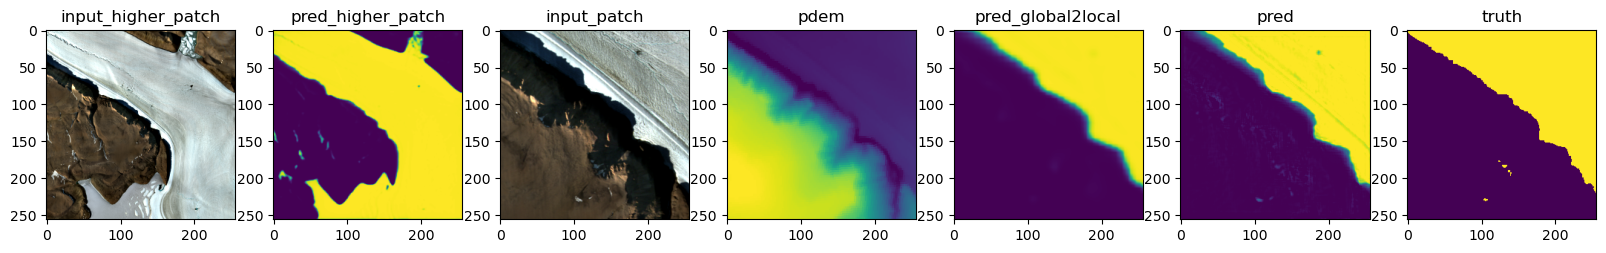

Ep161: tra-> Loss:0.057,Oa:0.954,Miou:0.931, val-> Loss:0.094,Oa:0.922, Miou:0.871,time:6.9s
Ep162: tra-> Loss:0.054,Oa:0.978,Miou:0.937, val-> Loss:0.094,Oa:0.919, Miou:0.869,time:7.6s
Ep163: tra-> Loss:0.055,Oa:0.979,Miou:0.937, val-> Loss:0.093,Oa:0.921, Miou:0.873,time:7.5s
Ep164: tra-> Loss:0.057,Oa:0.926,Miou:0.906, val-> Loss:0.093,Oa:0.927, Miou:0.877,time:7.7s
Ep165: tra-> Loss:0.063,Oa:0.964,Miou:0.939, val-> Loss:0.092,Oa:0.926, Miou:0.877,time:7.6s
Ep166: tra-> Loss:0.059,Oa:0.978,Miou:0.954, val-> Loss:0.089,Oa:0.922, Miou:0.875,time:7.6s
Ep167: tra-> Loss:0.060,Oa:0.984,Miou:0.969, val-> Loss:0.091,Oa:0.926, Miou:0.878,time:7.8s
Ep168: tra-> Loss:0.050,Oa:0.972,Miou:0.923, val-> Loss:0.090,Oa:0.922, Miou:0.876,time:7.7s
Ep169: tra-> Loss:0.053,Oa:0.985,Miou:0.970, val-> Loss:0.097,Oa:0.927, Miou:0.876,time:7.7s
Ep170: tra-> Loss:0.055,Oa:0.985,Miou:0.970, val-> Loss:0.092,Oa:0.923, Miou:0.877,time:7.9s


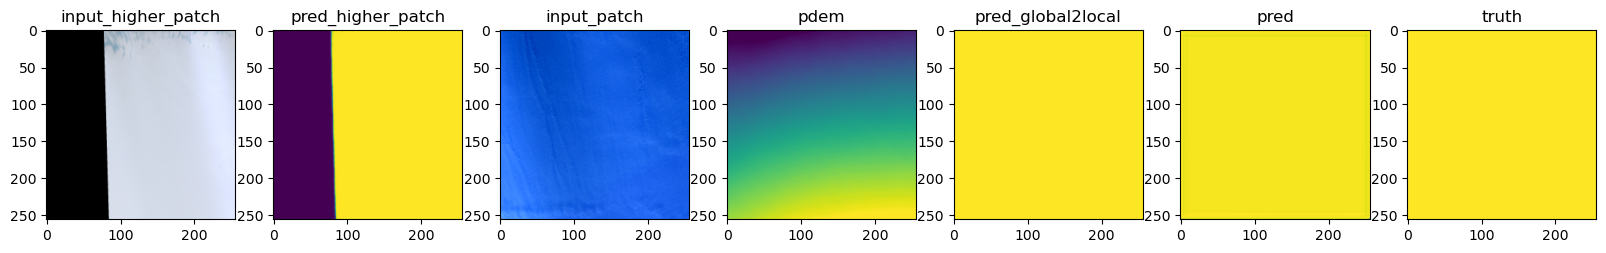

Ep171: tra-> Loss:0.065,Oa:0.961,Miou:0.944, val-> Loss:0.087,Oa:0.926, Miou:0.878,time:7.5s
Ep172: tra-> Loss:0.054,Oa:0.957,Miou:0.916, val-> Loss:0.090,Oa:0.922, Miou:0.868,time:7.6s
Ep173: tra-> Loss:0.060,Oa:0.980,Miou:0.961, val-> Loss:0.091,Oa:0.922, Miou:0.874,time:7.9s
Ep174: tra-> Loss:0.057,Oa:0.979,Miou:0.948, val-> Loss:0.093,Oa:0.922, Miou:0.874,time:7.7s
Ep175: tra-> Loss:0.052,Oa:0.982,Miou:0.966, val-> Loss:0.096,Oa:0.924, Miou:0.874,time:7.5s
Ep176: tra-> Loss:0.055,Oa:0.972,Miou:0.950, val-> Loss:0.090,Oa:0.923, Miou:0.876,time:7.8s
Ep177: tra-> Loss:0.057,Oa:0.941,Miou:0.916, val-> Loss:0.090,Oa:0.925, Miou:0.877,time:8.0s
Ep178: tra-> Loss:0.053,Oa:0.983,Miou:0.954, val-> Loss:0.090,Oa:0.924, Miou:0.877,time:8.1s
Ep179: tra-> Loss:0.054,Oa:0.973,Miou:0.952, val-> Loss:0.095,Oa:0.925, Miou:0.876,time:8.0s
Ep180: tra-> Loss:0.057,Oa:0.925,Miou:0.902, val-> Loss:0.093,Oa:0.922, Miou:0.875,time:7.7s


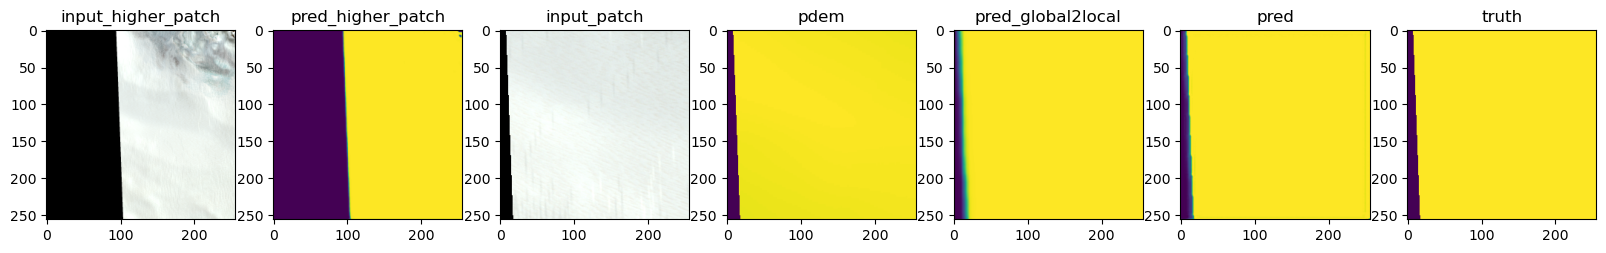

Ep181: tra-> Loss:0.051,Oa:0.945,Miou:0.906, val-> Loss:0.091,Oa:0.924, Miou:0.876,time:7.4s
Ep182: tra-> Loss:0.056,Oa:0.965,Miou:0.941, val-> Loss:0.096,Oa:0.922, Miou:0.872,time:7.7s
Ep183: tra-> Loss:0.056,Oa:0.935,Miou:0.905, val-> Loss:0.092,Oa:0.930, Miou:0.878,time:7.5s
Ep184: tra-> Loss:0.056,Oa:0.961,Miou:0.919, val-> Loss:0.096,Oa:0.928, Miou:0.877,time:7.7s
Ep185: tra-> Loss:0.056,Oa:0.967,Miou:0.927, val-> Loss:0.093,Oa:0.921, Miou:0.872,time:7.5s
Ep186: tra-> Loss:0.060,Oa:0.982,Miou:0.955, val-> Loss:0.091,Oa:0.925, Miou:0.873,time:7.9s
Ep187: tra-> Loss:0.062,Oa:0.977,Miou:0.959, val-> Loss:0.103,Oa:0.929, Miou:0.871,time:7.8s
Ep188: tra-> Loss:0.062,Oa:0.978,Miou:0.954, val-> Loss:0.088,Oa:0.927, Miou:0.876,time:7.8s
Ep189: tra-> Loss:0.061,Oa:0.973,Miou:0.948, val-> Loss:0.092,Oa:0.926, Miou:0.877,time:7.7s
Ep190: tra-> Loss:0.060,Oa:0.974,Miou:0.912, val-> Loss:0.092,Oa:0.922, Miou:0.876,time:7.8s


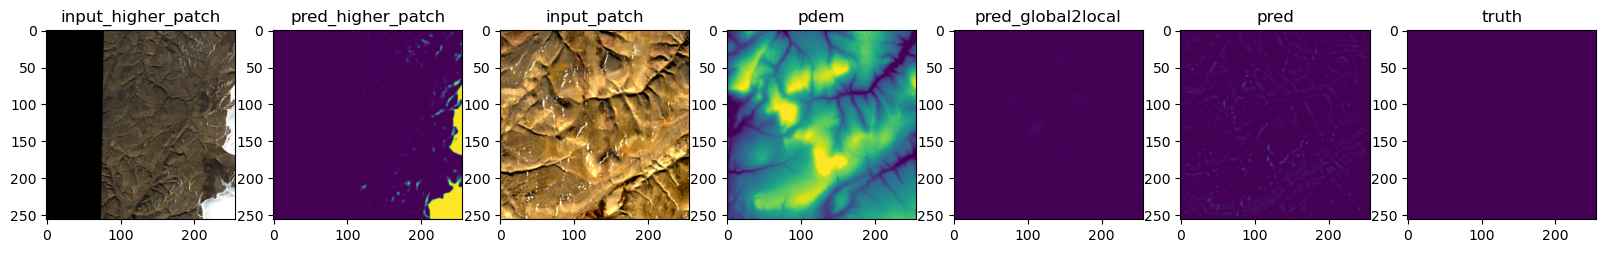

Ep191: tra-> Loss:0.055,Oa:0.978,Miou:0.955, val-> Loss:0.096,Oa:0.925, Miou:0.876,time:8.0s
Ep192: tra-> Loss:0.054,Oa:0.983,Miou:0.959, val-> Loss:0.094,Oa:0.925, Miou:0.877,time:8.0s
Ep193: tra-> Loss:0.058,Oa:0.981,Miou:0.946, val-> Loss:0.093,Oa:0.926, Miou:0.877,time:8.0s
Ep194: tra-> Loss:0.054,Oa:0.973,Miou:0.944, val-> Loss:0.090,Oa:0.931, Miou:0.879,time:7.8s
Ep195: tra-> Loss:0.048,Oa:0.941,Miou:0.901, val-> Loss:0.093,Oa:0.922, Miou:0.874,time:8.2s
Ep196: tra-> Loss:0.050,Oa:0.984,Miou:0.956, val-> Loss:0.094,Oa:0.925, Miou:0.877,time:7.5s
Ep197: tra-> Loss:0.056,Oa:0.983,Miou:0.945, val-> Loss:0.094,Oa:0.926, Miou:0.878,time:7.8s
Ep198: tra-> Loss:0.052,Oa:0.976,Miou:0.945, val-> Loss:0.092,Oa:0.924, Miou:0.878,time:7.7s
Ep199: tra-> Loss:0.058,Oa:0.939,Miou:0.922, val-> Loss:0.098,Oa:0.926, Miou:0.876,time:7.6s
Ep200: tra-> Loss:0.054,Oa:0.925,Miou:0.897, val-> Loss:0.093,Oa:0.931, Miou:0.877,time:7.7s


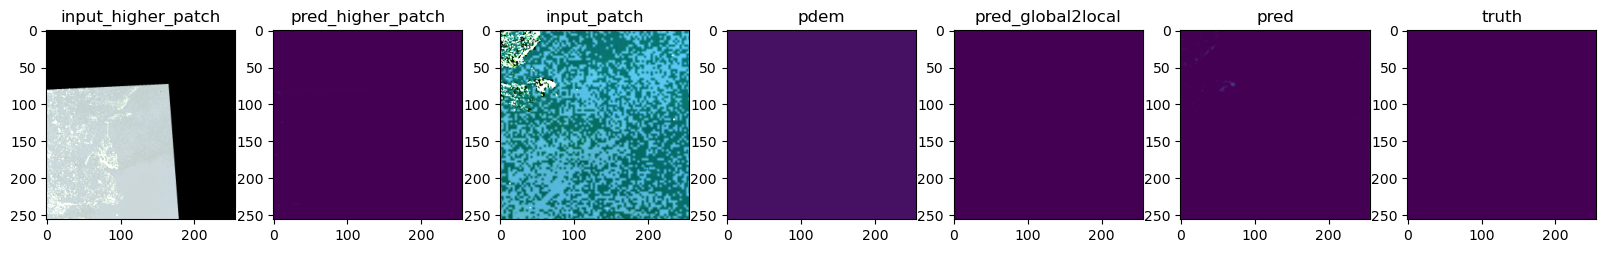

In [12]:
device = torch.device('cuda:0')  
metrics = train_loops(model=model,  
                      epoches=200,  
                      loss_fn=loss_scales,  
                      optimizer=optimizer,  
                      lr_scheduler=lr_scheduler,   
                      tra_loader=tra_loader,   
                      val_loader=val_loader,  
                      device=device)  


In [ ]:
### model saving
model_name = 'unet'
### net_name = 'deeplabv3plus'
### net_name = 'deeplabv3plus_mb2'
path_save = f'model/trained/{model_name}_{patch_size}_{higher_patch_size}/{model_name}_1.pth'
torch.save(model.state_dict(), path_save)   ## save weights of the trained model 
# # model.load_state_dict(torch.load(path_save, weights_only=True))  # load the weights of the trained model
# # ## metrics saving
path_metrics = f'model/trained/{model_name}_{patch_size}_{higher_patch_size}/{model_name}_metrics_1.csv'
metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv(path_metrics, index=False, sep=',')

